In [1]:
from functools import partial
from pathlib import Path
from turtle import color
from setuptools_scm import meta
import torch
import numpy as np
import matplotlib.pyplot as plt

from sbi.inference import simulate_for_sbi

from hnpe.misc import make_label
from hnpe.posterior import build_flow, IdentityJRNMM
from hnpe.simulator import prior_JRNMM, simulator_JRNMM
from hnpe.summary import summary_JRNMM
from hnpe.viz import get_posterior
from hnpe.eval_sim import plot_pairgrid_with_groundtruth

from diagnostics.pp_plots import multi_cde_pit_values, PP_plot_1D
from diagnostics.localPIT_regression import localPIT_regression_baseline

from data.feature_transforms import identity


In [2]:
# PATH
PATH_EXPERIMENT = 'saved_experiments/JR-NMM/'

# DATASETS
B = 50_000
B_PRIME = 10_000
B_DOUBLE_PRIME = 10_000
N_SAMPLES_POSTERIOR = 10_000


## SBI Task: Prior and Simulator 

- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000],[-20,20])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) \text{, where} \theta = (C, \mu, \sigma, g)$$
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$

**Goal:** estimate $p(\theta\mid x_0)$ with a Normalizing Flow $q_{\phi}(\theta \mid s(x_0), \mathcal{X})$ with $x_0$ an observation and $\mathcal{X}$ a set of extra observations.

In [29]:
# DATA FEATURES
N_EXTRA = 0
SINGLE_REC = False
T_REC = 8

# MODEL FEATURES
NAIVE = True  # use NAIVE OR HNPE
method = 'naive'*NAIVE + 'hnpe'*(1-NAIVE)

# EXPERIMENTAL SETUP
meta_parameters = {}
# Summary Features
meta_parameters["summary"] = "Fourier"
meta_parameters["n_sf"] = 33
# Training Features
meta_parameters["n_rd"] = 1  # amortized flow
meta_parameters["n_sr"] = B  # simulations per round


In [30]:
# SBI Task: Inference of the JR-NMM parameters under uniform prior

# Prior
prior = prior_JRNMM(parameters=[('C', 10.0, 250.0),
                                ('mu', 50.0, 500.0),
                                ('sigma', 100.0, 5000.0),
                                ('gain', -20.0, +20.0)])

# Simulator
simulator = partial(simulator_JRNMM,
                    input_parameters=['C', 'mu', 'sigma', 'gain'],
                    t_recording=T_REC,
                    n_extra=N_EXTRA,
                    p_gain=prior,
                    single_recording=False)  

# Summary features
summary_extractor = summary_JRNMM(n_extra=N_EXTRA,
                            d_embedding=meta_parameters['n_sf'],
                            n_time_samples=int(128*T_REC),
                            type_embedding=meta_parameters['summary'])
summary_extractor.embedding.net.logscale = True  # log-PSD         

In [31]:
# Observation
theta_true = torch.FloatTensor([135.0, 220.0, 2000.0, 0.0])

# example cases we are considering here
meta_parameters["case"] = PATH_EXPERIMENT+"Flows_amortized/JRNMM_nextra_{:02}_trec_{}" \
                "naive_{}_" \
                "single_rec_{}_"\
                "C_{:.2f}_" \
                "mu_{:.2f}_" \
                "sigma_{:.2f}_" \
                "gain_{:.2f}".format(N_EXTRA,
                                    T_REC,
                                    NAIVE,
                                    SINGLE_REC,
                                    theta_true[0],
                                    theta_true[1],
                                    theta_true[2],
                                    theta_true[3])

# label for saving directory of experiments
meta_parameters["label"] = make_label(meta_parameters)
folderpath = Path.cwd() / meta_parameters["label"]

# get ground-truth observation
ground_truth = torch.load(folderpath/'ground_truth.pkl')
x_obs = ground_truth['observation'] # torch.Size([1, 33, 1])
torch.save(x_obs, PATH_EXPERIMENT+f'Flows_amortized/gt_observation_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}.pkl')


## Train Estimator: HNPE 
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$. 
the estimator actually trains on the summary statisctics of the time series $x_i = \text{Summary}(\text{Simulator}(\theta_i))$, accompanied by a certain number of extra observations. 

In [32]:
filename = PATH_EXPERIMENT+f'Flows_amortized/{method}_posterior_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}.pkl'
if os.path.exists(filename):
        posterior = torch.load(filename)
else: 
    # choose a function which creates a neural network density estimator
    build_nn_posterior = partial(build_flow, 
                                embedding_net=IdentityJRNMM(),
                                naive=NAIVE,
                                aggregate=True,
                                z_score_theta=True,
                                z_score_x=True)  

    # get posterior 
    posterior = get_posterior(
        simulator, prior, summary_extractor, build_nn_posterior,
        meta_parameters, round_=0
    ).net
    torch.save(posterior, filename)

## WHY we need Validation and WALDO

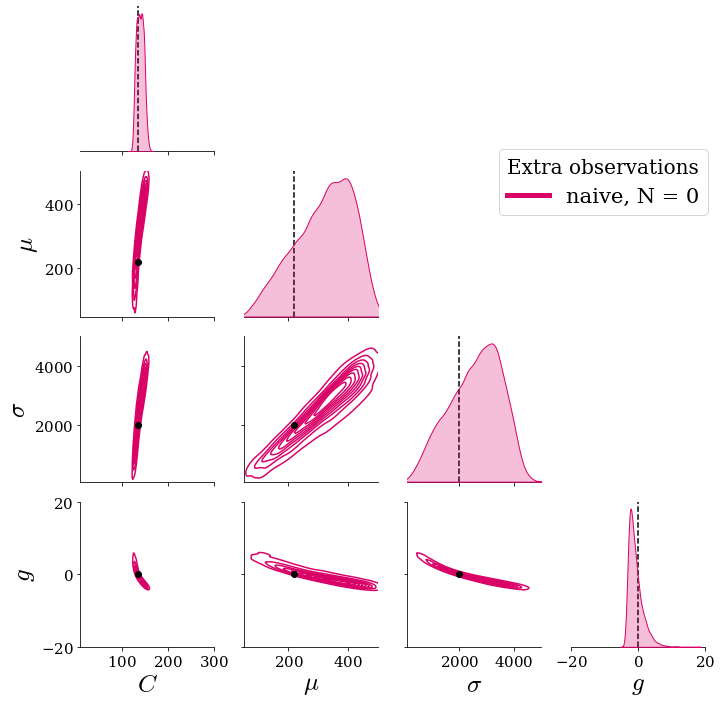

In [33]:
# Plot learned posteriors with true parameters 
cases = {
    'naive': [(0,False)], 
    # 'hnpe':[(0,False)]#, (9, False), (9,True)]
}
posteriors = {}
context = {}
for exp in list(cases.keys()):
    for i,(n_extra, single_rec) in enumerate(cases[exp]):
        filename_posterior = PATH_EXPERIMENT+'Flows_amortized/'+exp+f'_posterior_nextra_{n_extra}_single_rec_{single_rec}.pkl'
        filename_xobs = PATH_EXPERIMENT+f'Flows_amortized/gt_observation_nextra_{n_extra}_single_rec_{single_rec}.pkl'
        label = exp+f', N = {n_extra}'
        if exp != 'naive':
            if single_rec:
                label+=', single rec'
            # else:
            #     if n_extra != 0:
            #         label+=', hierarchical'
        posteriors[label]= torch.load(filename_posterior)
        context[label] = torch.load(filename_xobs)

color_dict = dict(zip(list(posteriors.keys()), ['#D90368', 'blue', '#FFA500']))

plot_pairgrid_with_groundtruth(
    posteriors=posteriors,
    context = context,
    theta_gt=list(theta_true.numpy()),
    color_dict=color_dict,
    handles=[
        plt.Line2D([], [], color=color_dict[label], linewidth=5, label=label) for label in list(posteriors.keys())
    ],
    n_samples=N_SAMPLES_POSTERIOR
)


The result is not satisfying. The stochasticity of the simulator makes the problem ill-posed and the learned posterior does not concentrate around the true parameters (black points). The observation $x_0$ might not be the most likely sample of $p(x\mid \theta_0)$.

This can be solved using multiple extra observations. We show the results for 2 different ways of using these extra-observations:
- ORANGE: extra-observations $\mathcal{X}$ are generated using the **same parameters** $\theta_0$ as the main observation $x_0$
- BLUE: HNPE, parameters follow a **hierarchical modelling** scheme to further solve the indeterminacy between coupled parameters.

The goal is to see if we can capture this overconfidence/misspecification of the estimator using **no extra observations** with our validation diagnostics.

WALDO as a last step will make sure the true parameter will be included in the confidece region, but we wish to have an evaluation of the estimator itself before doing that. 

## Data Generation

In [34]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT + f"datasets_{method}.pkl"

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    # b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_PRIME
    )
    b_prime_x = summary_extractor(b_prime_x)
    b_double_prime_theta, b_double_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_DOUBLE_PRIME
    )
    b_double_prime_x = summary_extractor(b_double_prime_x)

    datasets = {
        # "B": {"theta": b_theta, "x": b_x},
        "B_prime": {"theta": b_prime_theta, "x": b_prime_x},
        "B_double_prime": {"theta": b_double_prime_theta, "x": b_double_prime_x},
    }
    torch.save(datasets, filename)

datasets['B_prime']['theta'].shape, datasets['B_prime']['x'].shape

(torch.Size([10000, 4]), torch.Size([10000, 33, 1]))

## Global vs. Local Coverage (`n_extra = 0`)

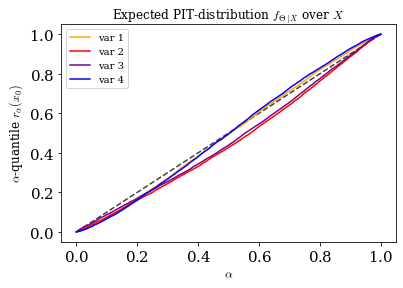

In [35]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_prime']['theta'], datasets['B_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_test, x_test, posterior, feature_transform=identity
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=[flow_joint_pit_values[0], flow_joint_pit_values[1], flow_joint_pit_values[2], flow_joint_pit_values[3]],
    alphas=np.linspace(0, 1, 100),
    colors=["orange", "red", "purple", "blue"],
    labels=["var 1", "var 2", "var 3", "var 4"],
    title=r"Expected PIT-distribution $f_{\Theta \mid X}$ over $X$",
)

Does not work because the flow is not amortized.

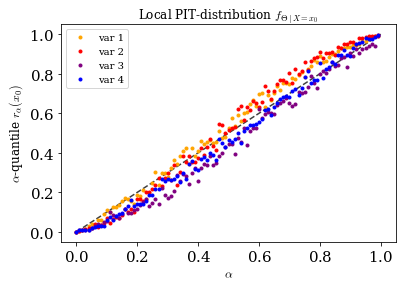

In [28]:
# PLOT LOCAL PIT-DISTRIBUTION of the trained estimators

# Load LEARNED local PIT-values
filename = PATH_EXPERIMENT + f"Flows_amortized/r_alpha_learned_naive_nextra_0.pkl"
r_alpha_learned = torch.load(filename)

# PP-plot of local PIT-distribution for both flows
# alpha-quantiles = [P_Theta|X_0(Z < alpha)]
PP_plot_1D(
    PIT_values=None,
    alphas=np.linspace(0, 0.99, 100),
    r_alpha_learned=[
        r_alpha_learned["dim_1"],
        r_alpha_learned["dim_2"],
        r_alpha_learned["dim_3"],
        r_alpha_learned["dim_4"],
    ],
    colors=["orange", "red"],
    colors_r_alpha=["orange", "red", "purple", "blue"],
    labels=["var 1", "var 2", "var 3", "var 4"],
    title=r"Local PIT-distribution $f_{\Theta \mid X=x_0}$",
)


**Application to JR_NMM (`NAIVE` flow with `n_extra = 0`): Results for Expected and Local PIT distribution.**

**Methods:**
- Multivariate case with covariate-wise PP-plots using *Rosenblatt Transformation method* computed with the flow transformation.
- Local PIT regression with the *baseline regression method* (one classifier per alpha-value)

**Quick Analysis:**
- The expected PIT-distribution for variables 1 and 4 seems to be fine (close to identity).
- The expected PIT-distribution for variable 2 and 3 shows a (very small) small bias.
- The local PIT-distribution for all the variables seems fine (close to identity).

This means that the flow was well trained and fits the dataset. 
**It doesn't represent the distance to the dirac function** of the ground-truth parameters (black points) which is due to the stochasticity and parameter-coupling of the model. This is because the pit-distributions are computed on a dataset from the simple joint distribution (like the training set), without extra observations and hierarchical modelling.  